In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2063495540390575595]

In [2]:
import tensorflow as tf

tf.config.list_physical_devices('XLA_GPU')
tf_device='/gpu:0'
tf.test.is_built_with_cuda()


True

In [3]:
import mlreflect
print('Tested with mlreflect version: ' + mlreflect.__version__)
from mlreflect.utils import check_gpu
check_gpu() # Checks if a GPU on the current machine is available


Tested with mlreflect version: 0.21.1
[]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from mlreflect.curve_fitter import example_ascii_file_path, DefaultSpecFitter
from mlreflect.data_generation import Layer, Substrate, AmbientLayer, MultilayerStructure
from mlreflect.models import TrainedModel
from mlreflect.data_generation import ReflectivityGenerator
from mlreflect.training import Trainer
from mlreflect.curve_fitter import CurveFitter

In [5]:
experiment = np.loadtxt("data/data800.txt")
experiment_data = experiment[:,:]


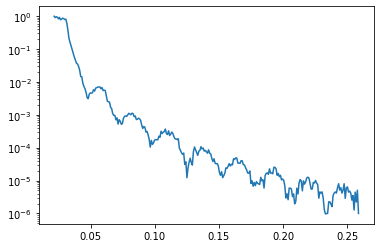

In [6]:
q = experiment[:, 0] # Extract q values
#experimental_reflectivity = experiment[:, 1:].T # Extract intensity values

plt.plot(q, experiment_data[:,1])
plt.yscale('log')
plt.show()

In [7]:
# Your sample model - settings

substrate = Substrate('Si', 1.1, 19.83)
layer1 = Layer('SiOx', 992, 2.6, 18.709) #17.77
layer2 = Layer('Film', (140, 350), (4, 14), (6, 11.5))
ambient = AmbientLayer('ambient', 0)

In [8]:
sample = MultilayerStructure()
sample.set_substrate(substrate)
sample.set_ambient_layer(ambient)
sample.add_layer(layer1)
sample.add_layer(layer2)

In [9]:
trainer = Trainer(sample, q, random_seed=10)

In [10]:
trainer.generate_training_data(2**19)

100%|██████████| 524288/524288 [01:18<00:00, 6669.58it/s]


In [11]:
generator = ReflectivityGenerator(q, sample)

In [12]:
#with tf.device('/device:GPU:0'):
trained_model, hist = trainer.train(n_epochs=15, batch_size=512, verbose=1)

Train for 819 steps, validate for 204 steps
Epoch 1/15
819/819 [==============================] - ETA: 4:49 - loss: 0.344 - ETA: 1:24 - loss: 0.653 - ETA: 55s - loss: 0.509 - ETA: 43s - loss: 0.38 - ETA: 37s - loss: 0.31 - ETA: 33s - loss: 0.27 - ETA: 30s - loss: 0.23 - ETA: 29s - loss: 0.20 - ETA: 27s - loss: 0.18 - ETA: 26s - loss: 0.16 - ETA: 25s - loss: 0.15 - ETA: 24s - loss: 0.14 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.12 - ETA: 22s - loss: 0.11 - ETA: 22s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.08 - ETA: 20s - loss: 0.08 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.05 - ETA: 18s - loss: 0.05 - ETA: 18s - loss: 0.05 - ETA: 18s - loss: 0.05 - ETA: 17s - loss: 0.05 - ETA: 17s - loss: 0.05 - ETA: 17s - loss: 0.04 - ETA: 17s - loss: 0.04 - ETA: 17s 

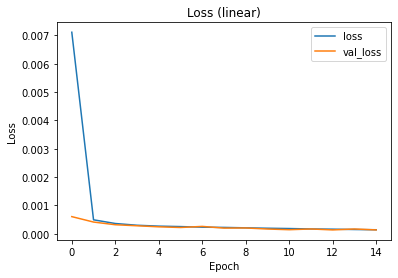

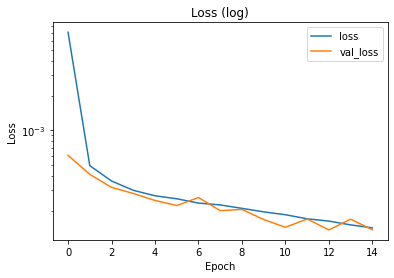

In [13]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (linear)')
plt.legend()
plt.show()

plt.semilogy(hist.history['loss'], label='loss')
plt.semilogy(hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (log)')
plt.legend()
plt.show()

In [14]:
curve_fitter = CurveFitter(trained_model)

In [15]:
test_labels = generator.generate_random_labels(2**10)
test_reflectivity = generator.simulate_reflectivity(test_labels)

100%|██████████| 1024/1024 [00:00<00:00, 3815.61it/s]


In [16]:
fit_output = curve_fitter.fit_curve(test_reflectivity, q, polish=False, optimize_q=False)

In [17]:
predicted_test_labels = fit_output['predicted_parameters']
predicted_test_reflectivity = fit_output['predicted_reflectivity']

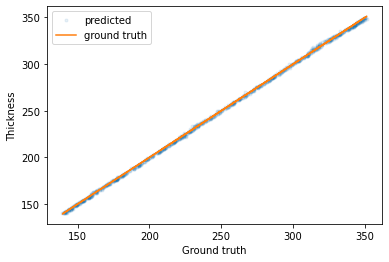

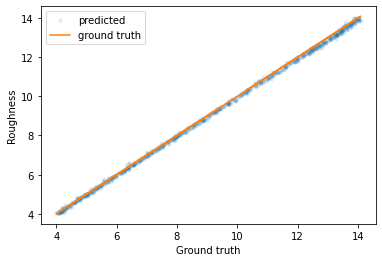

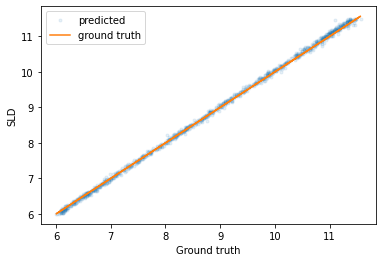

In [18]:
plt.plot(predicted_test_labels['Film_thickness'], test_labels['Film_thickness'], '.', label='predicted', alpha=0.1)
plt.plot(predicted_test_labels['Film_thickness'], predicted_test_labels['Film_thickness'], label='ground truth')
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('Thickness')
plt.show()

plt.plot(predicted_test_labels['Film_roughness'], test_labels['Film_roughness'], '.', label='predicted', alpha=0.1)
plt.plot(predicted_test_labels['Film_roughness'], predicted_test_labels['Film_roughness'], label='ground truth')
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('Roughness')
plt.show()

plt.plot(predicted_test_labels['Film_sld'], test_labels['Film_sld'], '.', label='predicted', alpha=0.1)
plt.plot(predicted_test_labels['Film_sld'], predicted_test_labels['Film_sld'], label='ground truth')
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('SLD')
plt.show()

In [19]:
# Saving your trained model:

trained_model.save_model("Trained_model.h5")

In [20]:
# Predict your experimental data:
my_trained_model = TrainedModel()
my_trained_model.from_file("Trained_model.h5")

curve_fitter = CurveFitter(my_trained_model)

In [21]:
experiment = np.loadtxt("data/data574.txt")
experiment_data = experiment[:,:]

experimental_intensity = experiment_data[:,1]
q_exp = experiment_data[:,0]
q = experiment[:, 0]

experimental_fit_output = curve_fitter.fit_curve(experimental_intensity, q, polish=False, optimize_q=False, optimize_scaling=True)
pred_experimental_reflectivity = experimental_fit_output['predicted_reflectivity']
pred_experimental_test_labels = experimental_fit_output['predicted_parameters']

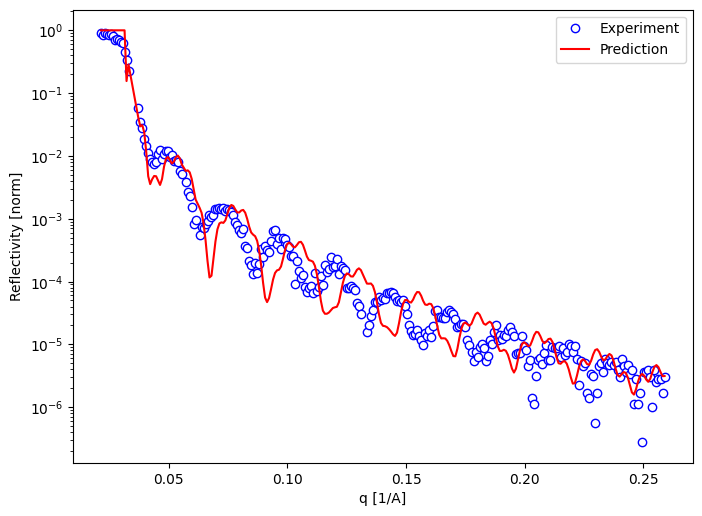

0    243.986328
Name: Film_thickness, dtype: float32


In [22]:
fig = plt.figure(dpi = 100, figsize = (8, 6))
plt.semilogy(q, experimental_intensity, 'o', markerfacecolor = "white", markeredgecolor = "blue", label = "Experiment")
plt.semilogy(q, pred_experimental_reflectivity[0], label = "Prediction", color="red")
plt.legend()
plt.xlabel("q [1/A]")
plt.ylabel("Reflectivity [norm]")
plt.show()

#print(pred_experimental_test_labels)
x = pred_experimental_test_labels['Film_thickness']
print(x)

In [23]:
from tqdm import tqdm
###series
thickness = []
sld = []
roughness = []

#with tf.device('/device:XLA_GPU:0'):
for i in tqdm(range(573, 700)):
    experiment = np.loadtxt("data/data"+str(i)+".txt")
    experiment_data = experiment[:,:]
    experimental_intensity = experiment_data[:,1]
    q_exp = experiment_data[:,0]
    experimental_fit_output = curve_fitter.fit_curve(experimental_intensity, q, polish=True, optimize_q=False, optimize_scaling=True)
    pred_experimental_reflectivity = experimental_fit_output['predicted_reflectivity']
    pred_experimental_test_labels = experimental_fit_output['predicted_parameters']
    thickness.append(pred_experimental_test_labels['Film_thickness'])
    sld.append(pred_experimental_test_labels['Film_sld'])
    roughness.append(pred_experimental_test_labels['Film_roughness'])


for i in tqdm(range(700, 2000, 10)):
    experiment = np.loadtxt("data/data"+str(i)+".txt")
    experiment_data = experiment[:,:]
    experimental_intensity = experiment_data[:,1]
    q_exp = experiment_data[:,0]
    experimental_fit_output = curve_fitter.fit_curve(experimental_intensity, q, polish=True, optimize_q=False, optimize_scaling=True)
    pred_experimental_reflectivity = experimental_fit_output['predicted_reflectivity']
    pred_experimental_test_labels = experimental_fit_output['predicted_parameters']
    thickness.append(pred_experimental_test_labels['Film_thickness'])
    sld.append(pred_experimental_test_labels['Film_sld'])
    roughness.append(pred_experimental_test_labels['Film_roughness'])

for i in tqdm(range(2000, 6000, 50)):
    experiment = np.loadtxt("data/data"+str(i)+".txt")
    experiment_data = experiment[:,:]
    experimental_intensity = experiment_data[:,1]
    q_exp = experiment_data[:,0]
    experimental_fit_output = curve_fitter.fit_curve(experimental_intensity, q, polish=True, optimize_q=False, optimize_scaling=True)
    pred_experimental_reflectivity = experimental_fit_output['predicted_reflectivity']
    pred_experimental_test_labels = experimental_fit_output['predicted_parameters']
    thickness.append(pred_experimental_test_labels['Film_thickness'])
    sld.append(pred_experimental_test_labels['Film_sld'])
    roughness.append(pred_experimental_test_labels['Film_roughness'])

100%|██████████| 80/80 [00:33<00:00,  2.38it/s]


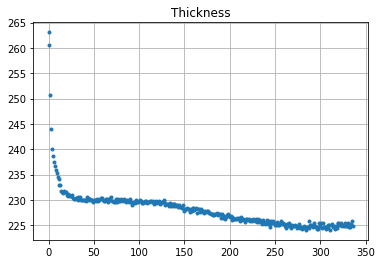

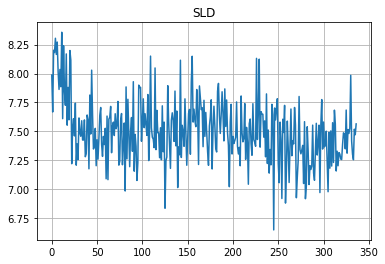

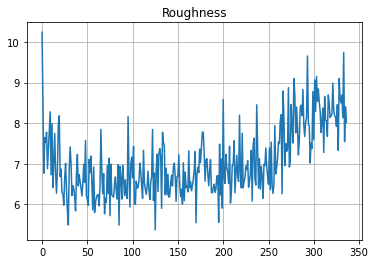

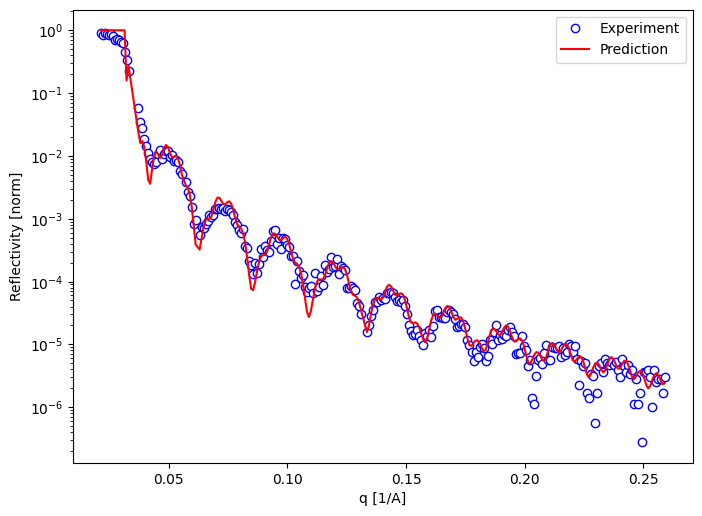

   SiOx_thickness  Film_thickness  Si_roughness  SiOx_roughness  \
0             992      263.089075           1.1             2.6   

   Film_roughness  Si_sld  SiOx_sld  Film_sld  ambient_sld  
0        8.397998   19.83    18.709  7.667113            0  


In [27]:
#TIME 8ms*4 - per curve
t1 = np.linspace(0,4064, 127)
t2 = np.linspace(4064,41600+4064, 130)
t3 = np.linspace(41600,128000+41600, 80)
t = np.array([t1,t2,t3])

plt.plot(thickness,".")
plt.grid()
plt.title('Thickness')
plt.show()

plt.plot(sld)
plt.grid()
plt.title('SLD')
plt.show()

plt.plot(roughness)
plt.grid()
plt.title('Roughness')
plt.show()

result = np.array([thickness, roughness, sld])
np.save('result_spin.npy', result)
np.save('t_spin.npy', t)

###single
experiment = np.loadtxt("data/data574.txt")
experiment_data = experiment[:,:]

experimental_intensity = experiment_data[:,1]
q_exp = experiment_data[:,0]

experimental_fit_output = curve_fitter.fit_curve(experimental_intensity, q, polish=True, optimize_q=False, optimize_scaling=True)
pred_experimental_reflectivity = experimental_fit_output['predicted_reflectivity']
pred_experimental_test_labels = experimental_fit_output['predicted_parameters']

fig = plt.figure(dpi = 100, figsize = (8, 6))
plt.semilogy(q, experimental_intensity, 'o', markerfacecolor = "white", markeredgecolor = "blue", label = "Experiment")
plt.semilogy(q, pred_experimental_reflectivity[0], label = "Prediction", color="red")
plt.legend()
plt.xlabel("q [1/A]")
plt.ylabel("Reflectivity [norm]")
plt.show()

print(pred_experimental_test_labels)

time1= (127,) time2= (130,) time3= (80,)
(337, 1)


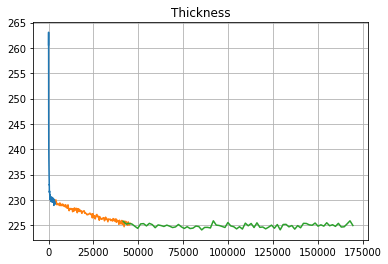

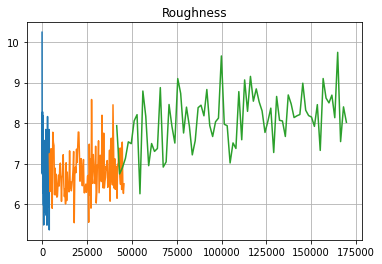

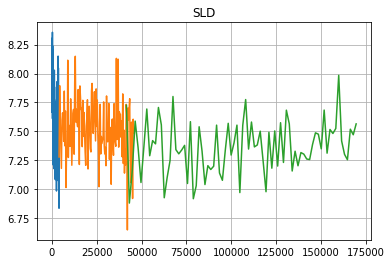

In [28]:
result= np.load('result_spin.npy', allow_pickle=True)
time = np.load('t_spin.npy', allow_pickle=True)

print('time1=', time[0].shape, 'time2=', time[1].shape,'time3=', time[2].shape)
print(result[1].shape)

plt.plot(time[0], result[0][:127])
plt.plot(time[1], result[0][127:257])
plt.plot(time[2], result[0][257:])
plt.title('Thickness')
plt.grid()
plt.show()

plt.plot(time[0], result[1][:127])
plt.plot(time[1], result[1][127:257])
plt.plot(time[2], result[1][257:])
plt.title('Roughness')
plt.grid()
plt.show()

plt.plot(time[0], result[2][:127])
plt.plot(time[1], result[2][127:257])
plt.plot(time[2], result[2][257:])
plt.title('SLD')
plt.grid()
plt.show()